<a href="https://colab.research.google.com/github/yunruyeh/111-2-AIcourse/blob/main/%E9%A2%A8%E6%A0%BC%E8%BD%89%E6%8F%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##### Copyright 2019 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Artistic Style Transfer with TensorFlow Lite

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/lite/examples/style_transfer/overview"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/style_transfer/overview.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/g3doc/examples/style_transfer/overview.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/tensorflow/tensorflow/lite/g3doc/examples/style_transfer/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

One of the most exciting developments in deep learning to come out recently is [artistic style transfer](https://arxiv.org/abs/1508.06576), or the ability to create a new image, known as a [pastiche](https://en.wikipedia.org/wiki/Pastiche), based on two input images: one representing the artistic style and one representing the content.

![Style transfer example](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/formula.png)

Using this technique, we can generate beautiful new artworks in a range of styles.

![Style transfer example](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/table.png)

If you are new to TensorFlow Lite and are working with Android, we
recommend exploring the following example applications that can help you get
started.

<a class="button button-primary" href="https://github.com/tensorflow/examples/tree/master/lite/examples/style_transfer/android">Android
example</a> <a class="button button-primary" href="https://github.com/tensorflow/examples/tree/master/lite/examples/style_transfer/ios">iOS
example</a>

If you are using a platform other than Android or iOS, or you are already
familiar with the
<a href="https://www.tensorflow.org/api_docs/python/tf/lite">TensorFlow Lite
APIs</a>, you can follow this tutorial to learn how to apply style transfer on any pair of content and style image with a pre-trained TensorFlow Lite model. You can use the model to add style transfer to your own mobile applications.

The model is open-sourced on [GitHub](https://github.com/tensorflow/magenta/tree/master/magenta/models/arbitrary_image_stylization#train-a-model-on-a-large-dataset-with-data-augmentation-to-run-on-mobile). You can retrain the model with different parameters (e.g. increase content layers' weights to make the output image look more like the content image).

## Understand the model architecture

![Model Architecture](https://storage.googleapis.com/download.tensorflow.org/models/tflite/arbitrary_style_transfer/architecture.png)

This Artistic Style Transfer model consists of two submodels:
1. **Style Prediciton Model**: A MobilenetV2-based neural network that takes an input style image to a 100-dimension style bottleneck vector.
1. **Style Transform Model**: A neural network that takes apply a style bottleneck vector to a content image and creates a stylized image.

If your app only needs to support a fixed set of style images, you can compute their style bottleneck vectors in advance, and exclude the Style Prediction Model from your app's binary.

## Setup

Import dependencies.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [ ]:
import IPython.display as display #引入 IPython.display 模組，這個模組提供了在 Jupyter Notebook 環境下顯示圖片、聲音和影片等多媒體資料的功能。

import matplotlib.pyplot as plt #引入 matplotlib.pyplot模組，matplotlib 是畫圖和繪圖的 Python 模組，它的子模組 pyplot 提供了簡單而強大的呼叫方式
import matplotlib as mpl #引入 matplotlib 模組，mpl 是 matplotlib 的另一個常用別名。
mpl.rcParams['figure.figsize'] = (12,12)    # 設定 matplotlib 繪相簿的預設圖形大小為 (12,12)
mpl.rcParams['axes.grid'] = False       # 不顯示格線。

import numpy as np     #引入 numpy 模組，numpy 是 Python 的一個科學計算的庫，提供了許多高效的數值計算方法。
import time          #引入 time 模組，time 模組主要是為了控制程式和子程式執行的時間。
import functools       #引入 functools 模組，functools 模組提供了帶有少量引數的函式，可以將原函式的輸入引數繫結，進而簡化函式呼叫的流程。

Download the content and style images, and the pre-trained TensorFlow Lite models.

In [ ]:
content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
style_path = tf.keras.utils.get_file('style23.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

284398/284398 [==============================] - 0s 0us/step


In [ ]:
!pip install pictures

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.5/765.5 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.0 MB/s eta 0:00:00
  Created wheel for pictures: filename=pictures-0.7-py3-none-any.whl size=4227 sha256=44af470d610585938d989b0607cb18c8580f142fc5bb48b8260800226c8d0bb7
  Stored in directory: /root/.cache/pip/wheels/30/7f/45/d7edfec5405eebafbd73a415311cac3d3ff40411c849700203
Successfully built pictures


## 導入自己的圖片

In [ ]:
# Monut Google drive 使用雲端照片
from google.colab import drive
drive.mount('/content/drive')

import pictures
content_path = '/content/drive/MyDrive/Colab Notebooks/人工智慧課程-Pictures/girl.jpeg'
style_path = '/content/drive/MyDrive/Colab Notebooks/人工智慧課程-Pictures/style.jpeg'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Pre-process the inputs 前處理步驟

* The content image and the style image must be RGB images with pixel values being float32 numbers between [0..1].
* The style image size must be (1, 256, 256, 3). We central crop the image and resize it.
* The content image must be (1, 384, 384, 3). We central crop the image and resize it.

內容影像和風格影像必須是 RGB 影像，畫素值應為浮點數，在 [0..1] 範圍之間。
風格影像的大小必須為 (1, 256, 256, 3)。 將裁剪影像並調整大小。
內容影像必須為 (1, 384, 384, 3)。 將裁剪影像並調整大小。

**將圖片轉換為浮點張量**的原因是為了讓模型能夠處理這些圖片。神經網路模型通常需要的輸入格式是浮點張量，這樣才能進行數值計算和梯度最佳化。
如果將圖片轉換為整數或位元組資料，這些資料在經過神經網路計算時會被當做分類、標籤值，不適合當做輸入資料。
另外，圖片的畫素值通常是在 0-255 之間的整數，轉換為浮點張量也可以將畫素值縮放到 0-1 之間，加速模型收斂和訓練，並提高模型的準確性。


**增加第一個 batch 維度**的原因是為了在處理多張圖片時能夠一次性處理所有圖片。在機器學習中，常常會以 batch 的方式對資料進行處理，即同時處理多個資料。而神經網路模型需要的輸入格式中第一個維度總是 batch 的大小。因此，為了讓單張圖片也能夠被當做 batch 的形式進行處理，我們需要將其轉換為一個大小為 1 的 batch，即對原來的 3D 張量 (height, width, channel) 加上一個新的維度，也就是變成了一個 4D 張量 (batch_size=1, height, width, channel)。這樣，即使只有一張圖片，我們也可以像處理多張圖片那樣一次輸入模型，這樣可以方便程式碼的編寫和計算的最佳化。

In [ ]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):     #`load_img` 函式用於從檔案載入影像並將其轉換為Tensor，這個函式的引數是圖片的路徑，返回值是一個 Tensor，代表著一個灰階或彩色圖片。這個函式會在 Tensor 的第一維加上一個 batch 的維度。
  img = tf.io.read_file(path_to_img) # 讀取圖片檔案
  img = tf.io.decode_image(img, channels=3) # 解碼圖片
  img = tf.image.convert_image_dtype(img, tf.float32)   # 將圖片轉換為浮點張量
  img = img[tf.newaxis, :] #增加第一個 batch 維度

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  #`preprocess_image` 函式用於對圖片進行預處理，調整影象的大小和中央裁剪。此函式的第一個引數是影象的 Tensor，
  # 第二個引數是影象的目標尺寸，返回值是一個 Tensor，代表著經過預處理的影象。此函式會將影象的較小的尺寸縮放到目標尺寸，裁剪影象並調整影象的大小到目標尺寸。
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim #將圖片最短的邊重新調整為目標維度

#圖片的長寬比例不會發生變化。如果圖片太小了，
#這個函式會放大圖片；反之如果圖片太大，則會縮小圖片，讓其最短邊等於目標維度。
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.從圖片中心擷取一個寬和高都等於目標維度的影象區域。
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.  #載入 input images（風格圖和內容圖）
content_image = load_img(content_path) #`content_path` 為檔案路徑，代表內容圖
style_image = load_img(style_path)   #`style_path` 為檔案路徑，代表風格圖

# Preprocess the input images. 運用預處理函式preprocess_image進行預處理
preprocessed_content_image = preprocess_image(content_image, 384) #將內容圖的尺寸調整成了 384x384
preprocessed_style_image = preprocess_image(style_image, 256)   #將風格圖的尺寸調整成了 256x256

print('Style Image Shape:', preprocessed_style_image.shape)   #運用 `Tensor.shape` 取得圖片 Tensor 的維度形狀，最後輸出預處理後的影像的維度。
print('Content Image Shape:', preprocessed_content_image.shape)

Style Image Shape: (1, 256, 256, 3)
Content Image Shape: (1, 384, 384, 3)


## Visualize the inputs

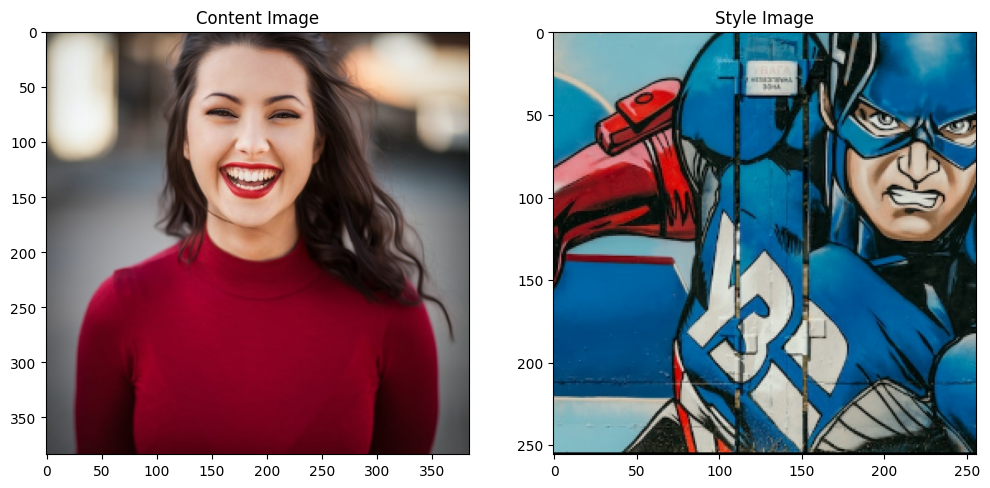

In [ ]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, 'Style Image')

## Run style transfer with TensorFlow Lite 轉移風格

### Style prediction

In [ ]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck = run_style_predict(preprocessed_style_image)
print('Style Bottleneck Shape:', style_bottleneck.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


### Style transform

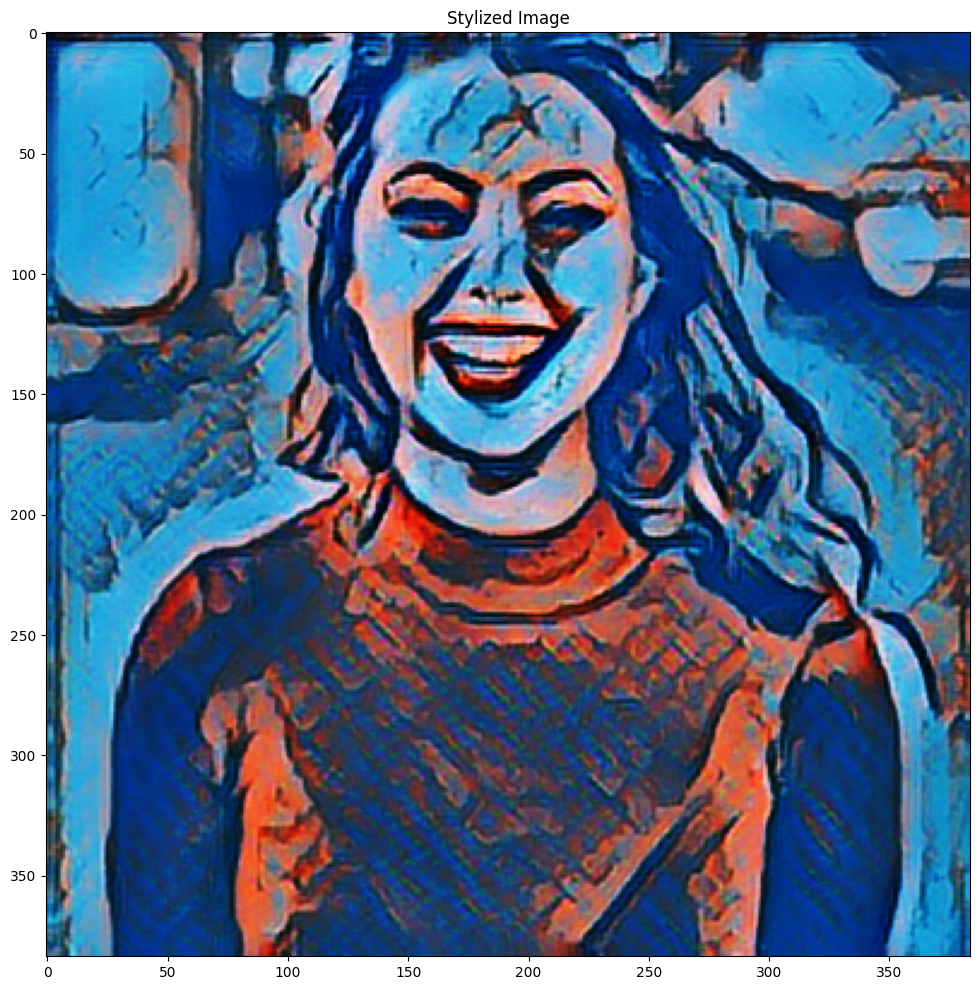

In [ ]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Stylized Image')

### Style blending 渲染

We can blend the style of content image into the stylized output, which in turn making the output look more like the content image.

In [ ]:
# Calculate style bottleneck of the content image.
style_bottleneck_content = run_style_predict(
    preprocess_image(content_image, 256)
    )

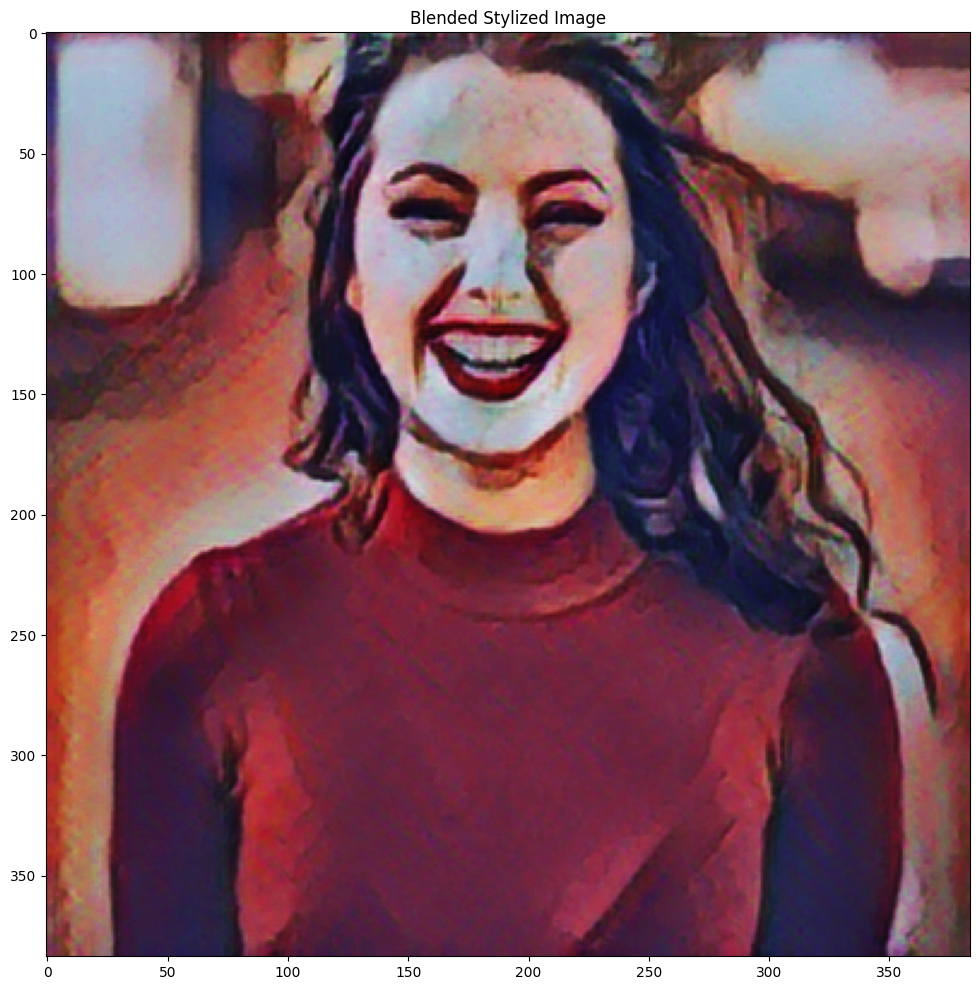

In [ ]:
# Define content blending ratio between [0..1].
# 0.0: 0% style extracts from content image.
# 1.0: 100% style extracted from content image.
content_blending_ratio = 0.8 #@param {type:"slider", min:0, max:1, step:0.01}

# Blend the style bottleneck of style image and content image
style_bottleneck_blended = content_blending_ratio * style_bottleneck_content \
                           + (1 - content_blending_ratio) * style_bottleneck

# Stylize the content image using the style bottleneck.
stylized_image_blended = run_style_transform(style_bottleneck_blended,
                                             preprocessed_content_image)

# Visualize the output.
imshow(stylized_image_blended, 'Blended Stylized Image')

## Performance Benchmarks

Performance benchmark numbers are generated with the tool [described here](https://www.tensorflow.org/lite/performance/benchmarks).
<table ><thead><tr><th>Model name</th> <th>Model size</th>  <th>Device </th> <th>NNAPI</th> <th>CPU</th> <th>GPU</th></tr> </thead>
<tr> <td rowspan = 3> <a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite">Style prediction model (int8)</a> </td>
<td rowspan = 3>2.8 Mb</td>
<td>Pixel 3 (Android 10) </td> <td>142ms</td><td>14ms*</td><td></td></tr>
<tr><td>Pixel 4 (Android 10) </td> <td>5.2ms</td><td>6.7ms*</td><td></td></tr>
<tr><td>iPhone XS (iOS 12.4.1) </td> <td></td><td>10.7ms**</td><td></td></tr>
<tr> <td rowspan = 3> <a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite">Style transform model (int8)</a> </td>
<td rowspan = 3>0.2 Mb</td>
<td>Pixel 3 (Android 10) </td> <td></td><td>540ms*</td><td></td></tr>
<tr><td>Pixel 4 (Android 10) </td> <td></td><td>405ms*</td><td></td></tr>
<tr><td>iPhone XS (iOS 12.4.1) </td> <td></td><td>251ms**</td><td></td></tr>

<tr> <td rowspan = 2> <a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/fp16/prediction/1?lite-format=tflite">Style prediction model (float16)</a> </td>
<td rowspan = 2>4.7 Mb</td>
<td>Pixel 3 (Android 10) </td> <td>86ms</td><td>28ms*</td><td>9.1ms</td></tr>
<tr><td>Pixel 4 (Android 10) </td><td>32ms</td><td>12ms*</td><td>10ms</td></tr>

<tr> <td rowspan = 2> <a href="https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/fp16/transfer/1?lite-format=tflite">Style transfer model (float16)</a> </td>
<td rowspan = 2>0.4 Mb</td>
<td>Pixel 3 (Android 10) </td> <td>1095ms</td><td>545ms*</td><td>42ms</td></tr>
<tr><td>Pixel 4 (Android 10) </td><td>603ms</td><td>377ms*</td><td>42ms</td></tr>

</table>

*&ast; 4 threads used. <br/>*
*&ast;&ast; 2 threads on iPhone for the best performance.*
